Imports :

In [2]:
import requests
import os, re
from datetime import datetime
from bs4 import BeautifulSoup
import json
import random

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

from typing import List, Dict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\floco\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Scrapper file :

In [3]:
# Scraper class for extracting nodes and links from nature.com articles
class Scraper:
    def __init__(self):
        # Initializing class variables
        self.base_url = "https://www.nature.com"
        self.universities = {}         # Dictionary to store universities and their occurrences
        self.collabs = {}              # Dictionary to store collaborations between universities
        self.mapping_univs = {}        # Mapping old university names to new names
        self.links_saved = []          # List to save article links used after

    # Method to load collaboration data from a JSON file
    def load_collabs(self, filename):
        with open(filename, 'r') as file:
            self.collabs = json.load(file)

    # Method to load university data from a JSON file
    def load_universities(self, filename):
        with open(filename, 'r') as file:
            self.universities = json.load(file)

    # Method to load saved links from a JSON file
    def load_links(self, filename):
        with open(filename, 'r') as file:
            self.links = json.load(file)

    # Method to save universities data to a JSON file
    def save_universities_in_file(self):
        with open('universities.json', 'w') as fp:
            json.dump(self.universities, fp)

    # Method to save collaborations data to a JSON file
    def save_collabs_in_file(self):
        with open('collabs.json', 'w') as fp:
            json.dump(self.collabs, fp)

    # Method to save saved links to a JSON file
    def save_links_in_file(self):
        with open('links.json', 'w') as fp:
            json.dump(self.links_saved, fp)

    # Method to retrieve HTML content of a given URL and parse it using BeautifulSoup
    def retrieve_url(self, url: str) -> BeautifulSoup:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        return soup

    # Method to create a mapping between old and new university names
    def create_map(self):
        for new_name in self.universities.keys():        
            for old_name in self.universities[new_name]['init_names']:
                if old_name not in self.mapping_univs:
                    self.mapping_univs[old_name] = new_name

    # Method to extract universities and collaboration data from nature.com articles
    def extract_universities(self):
        articles_counter = 1
        page = 1

        while True:
            search_url = f'{self.base_url}/search?journal=srep&article_type=research&subject=mathematics-and-computing&date_range=last_year&order=relevance&page={page}'
            soup = self.retrieve_url(search_url)

            all_atags = soup.find_all('a', {'data-track-action': 'view article'})

            if len(all_atags) == 0:
                break

            for atag in all_atags:
                random.seed(articles_counter)

                if(random.random() < 0.5):
                    self.parse_page(self.base_url + atag['href'], univs=True, collabs=False)
                    print(f"[EXTRACTING UNIVS] {articles_counter} articles and {len(self.universities)} universities found")
                else:
                    self.links_saved.append(atag['href'])
                    print(f"[EXTRACTING UNIVS] {articles_counter} articles found and {len(self.links_saved)} links saved")

                articles_counter += 1            
            page += 1

    # Method to extract collaboration data from nature.com articles
    def extract_collabs(self):
        articles_counter = 1
        page = 1

        while True:
            search_url = f'{self.base_url}/search?journal=srep&article_type=research&subject=mathematics-and-computing&date_range=last_year&order=relevance&page={page}'
            soup = self.retrieve_url(search_url)

            all_atags = soup.find_all('a', {'data-track-action': 'view article'})

            if len(all_atags) == 0:
                break

            for atag in all_atags:
                random.seed(articles_counter)

                if(random.random() < 0.5):
                    self.parse_page(self.base_url + atag['href'], univs=False, collabs=True)
                    print(f"[EXTRACTING COLLABS] {articles_counter} articles done")
                articles_counter += 1  
            page += 1

    # Method to print statistics about extracted data
    def print_stats(self):
        print(f'Number of nodes: {len(self.universities)}')
        links = 0
        links_with_fields = 0

        for u1 in self.collabs:
            for u2 in self.collabs[u1]:
                for u3 in self.collabs[u1][u2]:
                    links_with_fields += 1
                links += 1

        print(f'Number of links (without fields): {links}')
        print(f'Number of links (with fields): {links_with_fields}')

    # Method to parse the content of an article page and update dictionaries
    def parse_page(self, url: str, univs=True, collabs=True):
        soup = self.retrieve_url(url)

        try:
            # Find universities and update dictionaries
            authors_all = soup.findAll('p', class_='c-article-author-affiliation__address')
            subjects_all = soup.findAll('meta', {'name': 'dc.subject'})
        
            if univs:
                for s in authors_all:        
                    university = s.text        
                    if university not in self.universities:
                        self.universities[university] = 1
                    else:
                        self.universities[university] += 1

            if collabs:
                for s in authors_all:
                    try:
                        university = self.mapping_univs[s.text]

                        if university not in self.collabs:
                            self.collabs[university] = {}

                        alreadyAddedUniv = []
                        for s2 in authors_all:
                            try:
                                other_university = self.mapping_univs[s2.text]
                                if other_university not in alreadyAddedUniv:
                                    for sub in subjects_all:
                                        subject = sub.get('content')
                                        if university != other_university:
                                            if other_university not in self.collabs[university]:
                                                self.collabs[university][other_university] = {}

                                            if subject not in self.collabs[university][other_university]:
                                                self.collabs[university][other_university][subject] = 0

                                            self.collabs[university][other_university][subject] += 1
                                    alreadyAddedUniv.append(other_university)
                            except:
                                continue
                    except:
                        continue

        except Exception as error:
            print("[ERROR] Parse page: ", error) 

    # Method to preprocess university data
    def preprocess_universities(self):
        universities = {}

        for entry, count in self.universities.items():
            # Split the entry by commas and iterate through the parts
            parts = entry.split(',')

            # Look for patterns that match university names
            university = None
            for part in reversed(parts):
                if any(keyword in part for keyword in ["Polytechnic", "NIT", "MIT", "Politecnico", "Escuela", "École", "Institut", "Universitat", "Università", "Universität", "Universidad", "University", "Institute", "Ecole", "Universiti", "Université", "College", "School", "MIT"]):
                    university = part.strip()
                    break

            # If a university name is found, store the entry in the dictionary
            if university:
                if university in universities:
                    universities[university]['init_names'].append(entry)
                    universities[university]['count'] += count
                else:
                    universities[university] = {"init_names": [entry], "count": count}
            else:
                print(f"Not accepted this uni: {entry}")
            
        model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

        university_names = list(universities.keys())

        embeddings = model.encode(university_names, convert_to_tensor=True)

        similarity_matrix = cosine_similarity(embeddings, embeddings)

        threshold = 0.92
        similar_pairs = []

        for i in range(len(university_names)):
            for j in range(i + 1, len(university_names)):
                if similarity_matrix[i, j] > threshold:
                    similar_pairs.append((university_names[i], university_names[j]))

        similar_groups = []

        for pair in similar_pairs:
            found = False
            for group in similar_groups:
                if pair[0] in group or pair[1] in group:
                    group.add(pair[0])
                    group.add(pair[1])
                    found = True
                    break
            if not found:
                similar_groups.append({pair[0], pair[1]})

        similar_groups = [list(group) for group in similar_groups]

        for gr in similar_groups:
            first_uni = gr[0]

            for uni in gr[1:]:
                if first_uni in universities and uni in universities:
                    if 'init_names' not in universities[first_uni]:
                        universities[first_uni]['init_names'] = []
                    if 'count' not in universities[first_uni]:
                        universities[first_uni]['count'] = 0
                    universities[first_uni]['init_names'].extend(universities[uni].get('init_names', []))
                    universities[first_uni]['count'] = universities.get(first_uni, {}).get('count', 0) + universities.get(uni, {}).get('count', 0)
                    universities.pop(uni)

        universities = {key.strip(): value for key, value in universities.items()}

        self.universities = universities

Network stuff :

In [4]:
def create_edges(data, u1,u2):
    edges = []
    overall_weight = 0
    for collab in data.collabs[u1][u2].items():
        #print(collab)
        attr_dict = {'subject':collab[0], 'weight':collab[1]}
        edge = (u1, u2, attr_dict)
        edges.append(edge)

        overall_weight+=collab[1]
    #Edge with topic 'All'

    #Edge with topic 'All'
    overall_edge = (u1,u2, {'subject':'All','weight':overall_weight})
    edges.append(overall_edge)
    return edges        

In [5]:

def subjects_distribution(subjects, first_n):
    distrib = {}
    for subject, weight in subjects:
        if subject != 'All':
            distrib[subject] = distrib.get(subject,0) + weight
    width = 0.8 # width of the bars

    fig, ax = plt.subplots()

    ordered_items = sorted(distrib.items(),key=lambda x: x[1], reverse = True)[:first_n]
    xvalues = [subject for subject, value in ordered_items]
    yvalues = [value for subject, value in ordered_items]

    pprint(xvalues)



    rects1 = ax.bar(xvalues, yvalues, width, color='b')
    ax.set_title("Subject histogram")
    ax.set_xlabel("Subject")
    ax.set_xticks(range(len(xvalues)),xvalues, rotation = 90) # set the position of the x ticks
    ax.set_ylabel("# of link with this topic")
    plt.show()

In [6]:


def degree_distribution(G):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)

    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title("Connected components of G")
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

['Mathematics and computing',
 'Computer science',
 'Computational science',
 'Software',
 'Scientific data',
 'Applied mathematics',
 'Statistics',
 'Engineering',
 'Infectious diseases',
 'Biomarkers']


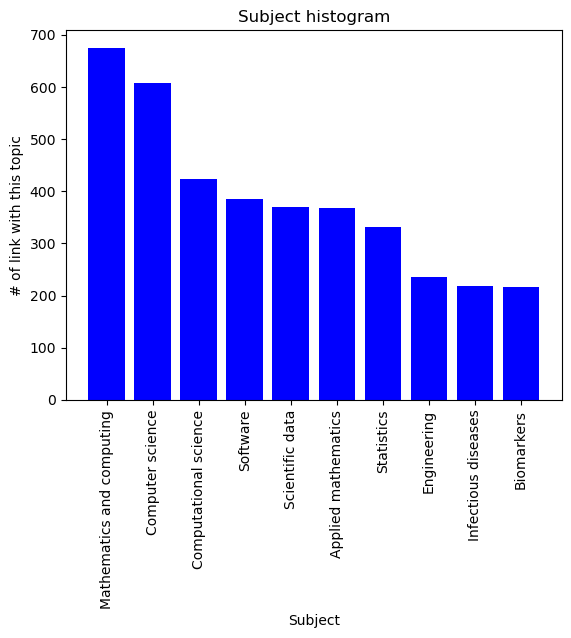

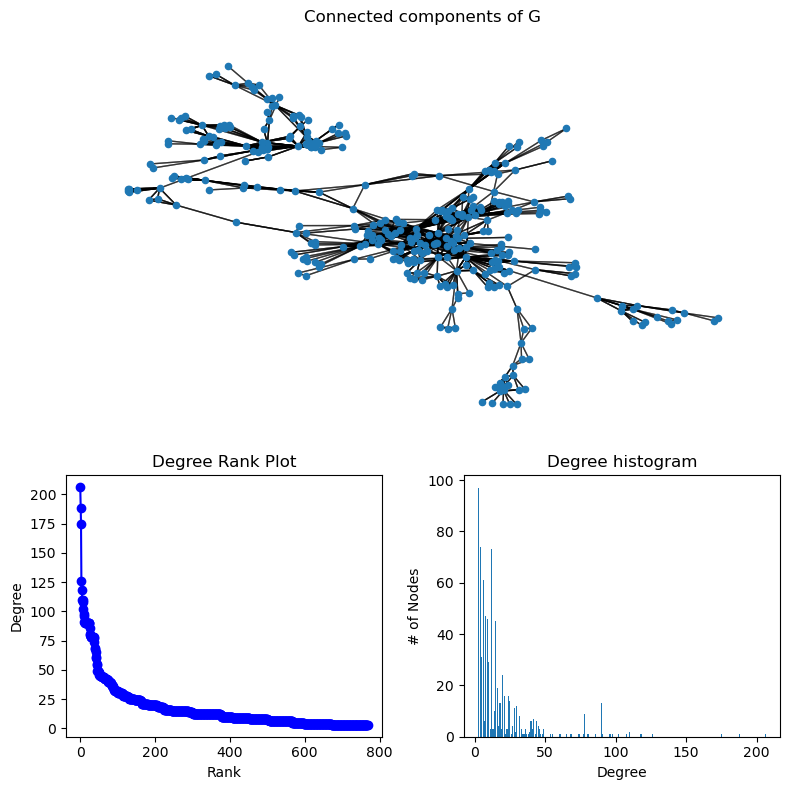

In [8]:
data = Scraper()
data.load_universities("universities.json")
data.load_collabs("collabs.json")

inserted_universities = {}
edges = []
nodes = []

for u1 in data.collabs:
    inserted_universities[u1] = True
    nodes.append(u1)
    for u2 in data.collabs[u1]:
        if not inserted_universities.get(u2,False):
            tmp_edges = create_edges(data,u1,u2)
            edges.extend(tmp_edges)

G = nx.MultiGraph()
G.add_edges_from(edges)

###THERE ARE 110 nodes that don't connect with anything soo
not_connected_nodes = set(nodes)-set(G.nodes())
########################################################


#Analyzing subjects
subjects = [(attr['subject'], attr['weight']) for node1, node2, attr in G.edges(data=True)]
first_n = 10
subjects_distribution(subjects, first_n)
subject_set = set([subj for subj, weight in subjects])

degree_distribution(G)